# Lab 1: Gaia, RR Lyrae Stars, and Galactic Dust

In [1]:
### IMPORT THE STUFF ###

import io
import os
import requests
import scipy.stats
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from astropy import units as u
from astropy.table import Table
from astropy.timeseries import LombScargle
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import TapPlus
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML
from joblib import Memory

In [2]:
### MAKE STUFF PRETTY ###
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context("poster")
sns.set_style("whitegrid")

In [16]:
### FUNCTIONS ###

### DATA RETRIEVAL ###

# cache directory for gaia queries
cachedir_query = './joblib_cache_gaia_query'
# 1e7 nytes (10 MB)
memory_query = Memory(
    cachedir_query, 
    verbose=0, 
    bytes_limit=1e7
)

@memory_query.cache
def get_gaia_query(q):
    """
    Submits an ADQL query to the
    Gaia archive to retrieve and
    store data in an astropy
    table.
    """
    start = time.time() # track time to carry out job
    job = Gaia.launch_job_async(q)
    print(f"Total time: {time.time()-start:0.2f} sec")
    return job.get_results()

def get_datalink(
    table, 
    data_release, 
    retrieval_type, 
    data_structure
):
    """
    Download from datalink raw light curves 
    with corresponding source ids in gaia query 
    and store to astropy table.
    
    INPUTS:
        Astropy table constructed from ADQL query
        of Gaia archive.
        
        Datalink meta data:
            data_release: 'Gaia DR3' (default), 'Gaia DR2'
            retrieval_type: 
                'EPOCH_PHOTOMETRY', <--- use this one
                'MCMC_GSPPHOT', 
                'MCMC_MSC', 
                'XP_SAMPLED', 
                'XP_CONTINUOUS',
                'RVS', 
                'ALL'
            data_structure: 
                'INDIVIDUAL',
                'COMBINED', <--- use this one
                'RAW'
    OUTPUT:
        Astropy data table
    """
    # retrieve datalink
    datalink = Gaia.load_data(
        ids = table['source_id'],
        data_release = data_release,
        retrieval_type = retrieval_type,
        data_structure = data_structure,
        verbose = False,
        output_file = None
    )
    # store data product keys
    dl_keys = [inp for inp in datalink.keys()]
    dl_keys.sort()
    dl_key = dl_keys[0]
    print(f'The following Datalink products have been downloaded:')
    for dl_key in dl_keys:
        print(f'* {dl_key}')
    # convert to astropy table
    result = datalink[dl_key][0].to_table()
    return result

### DATA RETRIEVAL ###

### ASTROPHYSICS EQUATIONS ####

def flux2mag(flux):
    return -2.5*np.log10(flux)

def mag2flux(mag):
    return 10**(-mag/2.5)

### ASTROPHYSICS EQUATIONS ####

### DATA PROCESSING ###

def filter_gband(table):
    
    tbl_g = table[table['band']=='G']
    tbl_g.sort('source_id')
    
    return tbl_g

def get_unique_source_ids(table):
    
    tbl_g = filter_gband(table)
    
    unique_source_ids = []
    
    unique_sources = np.unique(tbl_g['source_id'])
    
    for source in unique_sources:
        unique_source_ids.append(source)
    
    return unique_source_ids

def get_time_mag(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    
    return time, mag

### DATA PROCESSING ###

### DATA MANIPULATION ###

def estimate_period(table):
    
    """
    Takes in astropy table of light curve data
    from datalink and estimate the period for
    all light curves.
    """
    
    # empty list of period estimate
    period_est = []
    
    # filter table for G-band magnitude
    tbl_g = filter_gband(table)
    
    # save unique source id
    # to perform Lomb-Scargle for each unique source
    # to estimate period
    unique_sources = np.unique(table['source_id'])
    
    for source in unique_sources:
        # filter for one source
        tbl_g_sngl_src = tbl_g[(tbl_g['source_id'] == source)]
        
        # make arrays of magnitude and time
        time = np.array(tbl_g_sngl_src['time'])
        mag = np.array(tbl_g_sngl_src['mag'])
        # decompose with Lomb-Scargle
        freq, p_ls = LombScargle(
            time, mag, 
            fit_mean=False,
            center_data=True
        ).autopower(
            minimum_frequency=0,
            maximum_frequency=5,
            normalization='psd', # unnormalized periodogram;
                                 # comparable to Fourier power spectral density
            samples_per_peak=5
        )
        
        # index of largest power peak (non-NaN)
        pmax_idx = np.nanargmax(p_ls)
        
        # period value at max power
        # set to zero for division by zero
        if freq[pmax_idx] != 0:
            period = 1/freq[pmax_idx]
        else:
            period = 0
        
        # add estimated period value to list
        period_est.append(period)
        
    # directly return a float value
    # if there is only one source
    if len(period_est) == 1:
        return period_est[0]
    else:
        return period_est
    
def estimate_mean_magnitude(table):
    """
    Estimate the mean G-band magnitude for all
    light curves from datalink table by first
    calculating the mean flux.
    """
    # empty mean magnitude list
    mean_mag = []
    
    # filter table for G-band magnitude
    tbl_g = filter_gband(table)
    
    # save unique source id
    unique_sources = np.unique(table['source_id'])
    
    for source in unique_sources:
        # filter for one source
        tbl_g_sngl_src = tbl_g[(tbl_g['source_id'] == source)]
        
        # make arrays of magnitude and time
        mag = np.array(tbl_g_sngl_src['mag'])
        
        # estimate mean magnitude
        flux = mag2flux(mag)
        mean_flux = np.mean(flux)
        mean_m = flux2mag(mean_flux)
        
        # add value to list
        mean_mag.append(mean_m)
    
    # return float if only one value
    if len(mean_mag) == 1:
        return mean_mag[0]
    else:
        return mean_mag

def X_matrix(time, K, period):
    """
    Construct the X matrix of fourier terms.
    Inputs: 
        time array,
        estimated period (LS),
        K
    """
    X = []
    # angular frequency
    omega = (2*np.pi)/period
    
    for t in time:
        # empty row
        row = []
        # add the constant for A0
        row.append(1)
        
        for k in range(K):
            # add sine term
            row.append(np.sin((k+1)*omega*t))
            # add cosine term
            row.append(np.cos((k+1)*omega*t))
            
        X.append(row)
        
    return X

def least_squares(X, y):
    """
    Use least squares regression to
    solve for unknown coefficients
    in fourier representation.
    
    INPUTS:
        Matrix X of known quantities (time, period)
        Measured values y
    OUTPUTs:
        Coefficients
        Amongst other things (see np.linalg.lstsq doc)
    """
    return np.linalg.lstsq(X, y, rcond=None)

def reconstruct_mag(coef, time, K, period):
    """
    Reconstruct magnitude using fourier
    representation.
    
    INPUTS:
        Model coefficients from 
        least square solution (numpy array)
        
        Time (linspace or numpy array)
        Number of terms K (list)
        Period (float)
    OUTPUT:
        Fourier magnitudes (numpy array)
    """
    # create row from X matrix
    X = []
    omega = (2*np.pi)/period
    X.append(1)
    
    for k in range(K):
        X.append(np.sin((k+1)*omega*time))
        X.append(np.cos((k+1)*omega*time))
    
    # multiply row by model coefficients
    return np.matmul(X, np.transpose(coef))

def fourier_decomp(table, k, samples=500):
    # empty fourier mag list
    mag_fourier = []
    # filter table for G-band magnitude
    tbl_g = filter_gband(table)
    # save unique source id
    unique_sources = np.unique(table['source_id'])
    for source in unique_sources:
        # filter for one source
        tbl_g_sngl_src = tbl_g[(tbl_g['source_id'] == source)]
        # make arrays of magnitude and time
        time = np.array(tbl_g_sngl_src['time'])
        mag = np.array(tbl_g_sngl_src['mag'])
        period = np.array(estimate_period(tbl_g_sngl_src))
        y = mag
        # construct X with known values
        X = X_matrix(time, k, period)
        # solve for unknowns
        coef, residuals, rank, s = least_squares(X, y)
        # one pulsation period
        t = np.linspace(0, period, samples)
        # fourier magnitude for one pulsation period
        m_fourier = reconstruct_mag(coef, t, k, period)
        # append fourier magnitude to list
        mag_fourier.append(m_fourier)
    # directly returns 
    if len(mag_fourier) == 1:
        return mag_fourier[0]
    else:
        return mag_fourier
    
def get_fourier_mean_mag(mag):
    """
    Calculate fourier mean magnitude
    
    INPUTS:
        mag: 
            -array of shape (i,j)
            -i sources
            -j magnitude values
    """
    # empty mean magnitude list
    mag_mean_list = []
    # for each source
    for i in range(mag.shape[0]):
        # empty flux list
        flux_list = []
        # for every magnitude value
        for j in range(mag.shape[1]):
            # convert magnitude to flux
            # append flux value to flux list
            flux_list.append(10**(-mag[i][j]/2.5))                
        # take the mean of flux values in list
        flux_mean = np.mean(flux_list)               
        # convert mean flux to mean magnitude
        # append to mean magnitude list
        mag_mean_list.append((-2.5)*np.log10(flux_mean))

    return mag_mean_list

### DATA MANIPULATION ###

### PLOTTING ###

def plot_epoch_phot(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    source_id = tbl_g['source_id'][0]
    
    plt.scatter(
        time, mag,
        marker='.',
        color='red'
    )
    plt.title(f'Epoch Photometry in G-band for Source: {source_id}')
    plt.xlabel('Time [d]')
    plt.ylabel(r'$m_G$ [mag]')
    plt.grid()
    plt.tight_layout()
    
def plot_lomb_scargle(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    mag_error = np.array(tbl_g['mag_error'])
    source_id = tbl_g['source_id'][0]
    
    freq, p_ls = LombScargle(
        time, mag, mag_error,
        fit_mean=False, 
        center_data=True
    ).autopower(
        minimum_frequency=0,
        maximum_frequency=5.0,
        normalization='psd', # unnormalized periodogram;
                             # comparable to Fourier power spectral density
        samples_per_peak=5
    )
    plt.plot(freq, p_ls, c='black', zorder=1)
    plt.title(f'LS Periodogram for Source: {source_id}')
    plt.xlabel('frequency [1/d]')
    plt.ylabel('Spectral Power')
    plt.grid()
    plt.tight_layout()

def plot_phase_phot(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    source_id = tbl_g['source_id'][0]
    period = estimate_period(table)

    plt.scatter(
        time%period, mag,
        marker='.',
        color='black',
        label='phased light curve'
    )
    
    plt.title(f'Phase Photometry in G-band for Source: {source_id}')
    plt.xlabel('Phase [d]')
    plt.ylabel(r'$m_G$ [mag]')
    plt.grid()
    plt.tight_layout()

def plot_fourier_decomp(table, k):
    
    time, mag = get_time_mag(table)
    period = estimate_period(table)
    
    y = mag
    X = X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, y)
    
    t = np.linspace(0, period, 1000)
    m = reconstruct_mag(coef, t, k, period)
    
    plt.plot(t, m, linewidth=1.5, label=f'K = {k}', zorder=0)
    plt.tight_layout()
    
    return m

def plot_fourier_residual(table, K):
                             
    time, mag = get_time_mag(table)
    period = estimate_period(table)
    source_id = table['source_id'][0]
    y = mag
    
    for k in K:
        X = X_matrix(time, k, period)
        coef, residuals, rank, s = least_squares(X, y)
        m = reconstruct_mag(coef, time, k, period)
        residual = mag - m
        plt.scatter(time%period, residual, marker='.', s=10, label=f'K = {k}')
        
    plt.title(f'Fourier Magnitude Residual for Source: {source_id}')
    plt.xlabel('Phase [d]')
    plt.ylabel('Residuals [mag]')
    plt.grid()
    plt.legend(frameon=False, prop={'size':15}, bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()

### PLOTTING ###

In [6]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]
User: hnguye01
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


## 1. RR Lyrae GDR3

Write an ADQL query to download the first 100 rows of the table from the gaiadr3.vari_rrlyrae for which a $\textbf{fundamental pulsation frequency}$ (pf) has been measured and more than 40 clean epochs were obtained in the G-band. $\textbf{Display the first 10 rows of the catalog}$.

In [20]:
# query for RRab class RR Lyrae
query_RRab = """
    SELECT TOP 100 *
    FROM gaiadr3.vari_rrlyrae
    WHERE pf IS NOT NULL
    AND num_clean_epochs_g > 40
"""

# get query
tbl_RRab = get_gaia_query(query_RRab)

# sort by source_id for data comparison
tbl_RRab.sort('source_id')

# verify column names
# tbl_RRab.colnames

# verify that there are 100 rows
print(f'Full table size: {len(tbl_RRab)} rows')

# display the first 10 rows
tbl_RRab[:10]

INFO: Query finished. [astroquery.utils.tap.core]
Total time: 2.66 sec
Full table size: 100 rows


solution_id,source_id,pf,pf_error,p1_o,p1_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,epoch_rv,epoch_rv_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,average_rv,average_rv_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,peak_to_peak_rv,peak_to_peak_rv_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,num_clean_epochs_rv,zp_mag_g,zp_mag_bp,zp_mag_rp,num_harmonics_for_p1_g,num_harmonics_for_p1_bp,num_harmonics_for_p1_rp,num_harmonics_for_p1_rv,reference_time_g,reference_time_bp,reference_time_rp,reference_time_rv,fund_freq1,fund_freq1_error,fund_freq2,fund_freq2_error,fund_freq1_harmonic_ampl_g,fund_freq1_harmonic_ampl_g_error,fund_freq1_harmonic_phase_g,fund_freq1_harmonic_phase_g_error,fund_freq1_harmonic_ampl_bp,fund_freq1_harmonic_ampl_bp_error,fund_freq1_harmonic_phase_bp,fund_freq1_harmonic_phase_bp_error,fund_freq1_harmonic_ampl_rp,fund_freq1_harmonic_ampl_rp_error,fund_freq1_harmonic_phase_rp,fund_freq1_harmonic_phase_rp_error,fund_freq1_harmonic_ampl_rv,fund_freq1_harmonic_ampl_rv_error,fund_freq1_harmonic_phase_rv,fund_freq1_harmonic_phase_rv_error,best_classification,g_absorption,g_absorption_error
,,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,km / s,km / s,mag,mag,mag,mag,mag,mag,km / s,km / s,dex,dex,,,,,rad,rad,rad,rad,,,,,mag,mag,mag,,,,,d,d,d,d,1 / d,1 / d,1 / d,1 / d,mag,mag,rad,rad,mag,mag,rad,rad,mag,mag,rad,rad,km / s,km / s,rad,rad,,mag,mag
int64,int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,int16,int16,int16,int16,float64,float64,float64,float64,float64,float32,float64,float32,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float32,float32
375316653866487565,245002531050576896,0.5205123049162365,5.9112863e-06,--,--,1705.1323363868853,8.359822e-06,1705.1414775254216,1.0046097e-05,1705.1311474358477,6.545865e-06,--,--,15.929145,0.010242176,16.356573,0.018603276,15.278727,0.009487258,--,--,0.9385019,0.120727494,1.0994217,0.10973381,0.8165013,0.06977717,--,--,-0.8708563,0.47518787,0.47389403,0.08163338,0.31729943,0.05761884,4.024685,0.12488823,2.1125093,0.25776532,45,44,44,--,15.964044,16.411121,15.302456,4,3,4,--,1706.5856067422114,1706.5859002172215,1706.585988363658,--,1.921184169048463,2.1818254e-05,--,--,[0.32880035042762756 0.15581652522087097 0.10432817041873932 0.06540334969758987 -- -- -- -- -- -- -- -- -- -- -- --],[0.014035544358193874 0.027286922559142113 0.023547401651740074 0.0244175773113966 -- -- -- -- -- -- -- -- -- -- -- --],[1.2044552564620972 0.15041014552116394 5.725874900817871 5.31508207321167 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.09733834117650986 0.12707017362117767 0.20258760452270508 0.42948588728904724 -- -- -- -- -- -- -- -- -- -- -- --],[0.42022404074668884 0.18070216476917267 0.13100408017635345 -- -- -- -- -- -- -- -- -- -- -- -- --],[0.01920401118695736 0.024108218029141426 0.03326427564024925 -- -- -- -- -- -- -- -- -- -- -- -- --],[1.2882311344146729 0.151897594332695 5.8355512619018555 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0],[0.09742680191993713 0.1614372581243515 0.2745889723300934 -- -- -- -- -- -- -- -- -- -- -- -- --],[0.2656140923500061 0.14067623019218445 0.09007745236158371 0.06560894846916199 -- -- -- -- -- -- -- -- -- -- -- --],[0.010494326241314411 0.016995785757899284 0.016227422282099724 0.012636260129511356 -- -- -- -- -- -- -- -- -- -- -- --],[1.1146807670593262 0.13

$\textbf{TO DO: Read about RR-Lyrae parameters and their derivations from Clementini et al. 2016 and Clementini et al. 2022.}$

## 2. Raw Light Curves from Datalink

Download light curves (G-band magnitude vs. time, with magnitude uncertainties) from datalink for 100 RR Lyrae stars obtained above. Plot one light curve.

In [17]:
# datalink metadata
data_release = 'Gaia DR3'
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'COMBINED'

# datalink table
tbl_RRab_dtlnk = get_datalink(tbl_RRab, data_release, retrieval_type, data_structure)

# display table
tbl_RRab_dtlnk

The following Datalink products have been downloaded:
* EPOCH_PHOTOMETRY_COMBINED.xml


source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
,,,d,mag,electron / s,electron / s,,,,,
int64,int64,object,float64,float64,float64,float64,float32,bool,bool,int64,int64
245002531050576896,17127455701357856,G,1706.5856067422114,16.212044183497525,6167.782826967349,18.128442302557097,340.22684,False,False,5,375316653866487564
245002531050576896,18963346597122114,G,1739.7894840400877,16.201074379828846,6230.415279264763,9.977831359467514,624.4258,False,False,1,375316653866487564
245002531050576896,18973087399306294,G,1739.9656540065293,15.674993272493136,10114.616892818458,18.68724706674014,541.25775,False,False,1,375316653866487564
245002531050576896,24162597315961460,G,1833.815905206406,15.812720101377455,8909.610249734831,22.796642677841945,390.82993,False,False,1,375316653866487564
245002531050576896,24166689644275234,G,1833.8899083171,16.02193380294584,7348.068997789167,21.78705243163637,337.2677,False,False,1,375316653866487564
245002531050576896,24771107999851979,G,1844.8197651805692,16.011649605906094,7418.001289023465,21.9161359994418,338.47214,False,False,1,375316653866487564
...,...,...,...,...,...,...,...,...,...,...,...
6061905026177458176,71634819541917789,RP,2692.3274349217104,17.231708473861264,1015.0204936704503,22.011955277125747,46.112236,False,False,0,375316653866487564


In [ ]:
# DON'T RUN THIS CELL
# NEED TO FIGURE OUT
# PROPER CONVERSION
# WITH UNITS

# creating magnitude error column
flux_error = np.array(tbl_RRab_dtlnk['flux_error'])
mag_error = np.abs(flux2mag(flux_error))

# insert magnitude error after magnitude column
tbl_RRab_dtlnk.add_column(mag_error*u.mag, name='mag_error', index=5)

# check for mag_error column
tbl_RRab_dtlnk

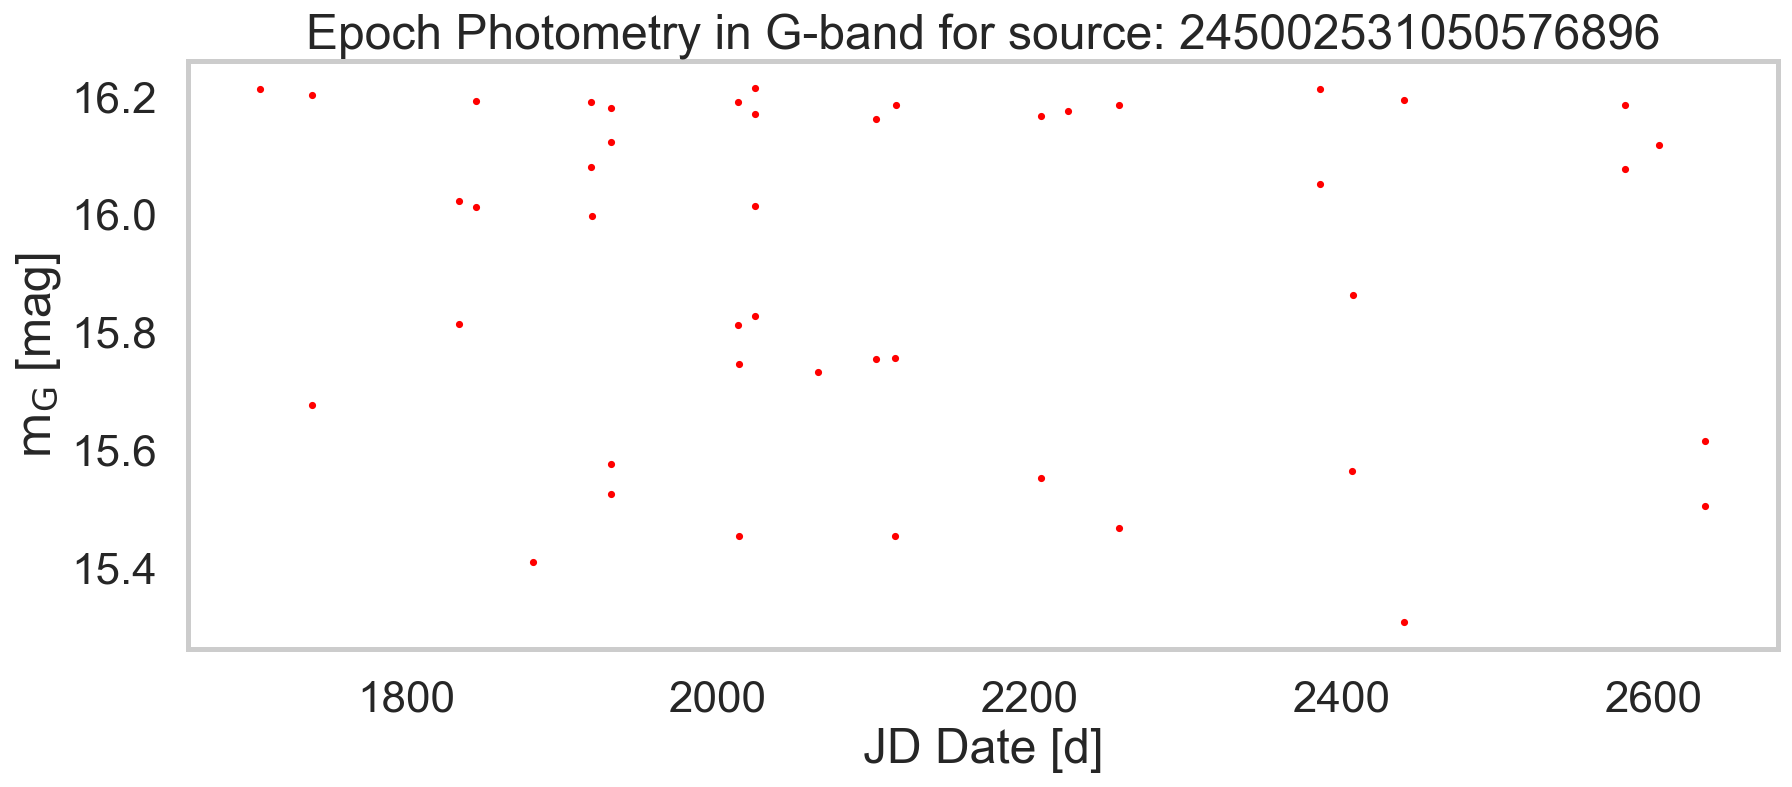

In [21]:
# filter table for one source
source_id = 245002531050576896 # first source
phot_set = tbl_RRab_dtlnk[
    (tbl_RRab_dtlnk['band'] == 'G') & 
    (tbl_RRab_dtlnk['source_id'] == source_id)
]
phot_set.sort('source_id')

# plotting a single light curve
plt.figure(figsize=(13,6))
plt.scatter(
    phot_set['time'],
    phot_set['mag'],
    marker='.',
    s=10,
    c='red'
)
plt.xlabel('JD Date [d]')
plt.ylabel(r'$\rm m_G$ [mag]')
plt.title(f'Epoch Photometry in G-band for source: {source_id}')
plt.grid()
plt.tight_layout()
plt.show()

## 1.1.3

Estimate the period and mean G-band magnitude of the 100 downloaded light curves using a Lomb-Scargle periodogram (astropy.timeseries.LombScargle). Plot the periodogram for one light curve and with the estimated period.
<br>

I'll do some preliminary work on a single source.
<br>

$\textbf{Clementinin et al. 2016}$: RR Lyrae classified with period $0.2 \leq P \leq 1$ which translates to a frequency range $1 \leq f \leq 5$.

In [ ]:
time = np.array(phot_set['time'])
mag = np.array(phot_set['mag'])
mag_error = np.array(phot_set['mag_error'])

# Get LS periodogram for source
freq, power = LombScargle(
    time, mag, mag_error,
    fit_mean=False, 
    center_data=True
).autopower(
    minimum_frequency=0,
    maximum_frequency=5,
    normalization='psd', # unnormalized periodogram;
                         # comparable to Fourier power spectral density
    samples_per_peak=5
)

# index of largest power peak (non-NaN)
power_max_idx = np.nanargmax(power)

# frequency value at max power
freq_pmax_val = freq[power_max_idx]

# estimated period value at max power
# set to zero if divide by zero
if freq_pmax_val != 0:
    period_est_val = 1/freq_pmax_val
else:
    period_est_val = 0

print(f'Frequency of largest power peak: {round(freq_pmax_val, 2)} cycle/day')
print(f'Estimated period: {round(period_est_val, 2)} day')

# plot LS periodogram
plt.figure(figsize=(13,6))
plt.plot(freq, power, c='black', zorder=1)
plt.scatter(
    freq_pmax_val, 0, 
    c='red', 
    label=f'Est. Period ~ {round(period_est_val, 2)} day', 
    zorder=2
)
plt.xlabel('frequency [1/d]')
plt.ylabel('Spectral Power')
plt.title(f'LS Periodogram for source: {source_id}')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# LS sinusoidal fit for phase plot
t_fit = np.linspace(0, 1, 200)
ls = LombScargle(time, mag, mag_error)
y_fit = ls.model(t_fit, freq_pmax_val)

plt.figure(figsize=(10,8))
plt.plot(t_fit, y_fit, c='black')
# phase plot
plt.errorbar(
    time%period_est_val,
    mag,
    yerr=mag_error,
    fmt='.',
    capsize=7,
    ecolor='blue',
    color='red',
)
plt.title(f'LS phase plot for source: {source_id}')
plt.xlabel('Phase')
plt.ylabel(r'$\rm m_G$ [mag]')
plt.grid()
plt.tight_layout()
plt.show()

Now let's estimate period for all 100 light curves

In [ ]:
def filter_gband(table):
    
    tbl_g = table[table['band']=='G']
    tbl_g.sort('source_id')
    
    return tbl_g

def get_unique_source_ids(table):
    
    tbl_g = filter_gband(table)
    
    unique_source_ids = []
    
    unique_sources = np.unique(tbl_g['source_id'])
    
    for source in unique_sources:
        unique_source_ids.append(source)
    
    return unique_source_ids

def estimate_period(table):
    
    """
    Takes in astropy table of light curve data
    from datalink and estimate the period for
    all light curves.
    """
    
    # empty list of period estimate
    period_est = []
    
    # filter table for G-band magnitude
    tbl_g = filter_gband(table)
    
    # save unique source id
    # to perform Lomb-Scargle for each unique source
    # to estimate period
    unique_sources = np.unique(table['source_id'])
    
    for source in unique_sources:
        # filter for one source
        tbl_g_sngl_src = tbl_g[(tbl_g['source_id'] == source)]
        
        # make arrays of magnitude and time
        time, mag = np.array(tbl_g_sngl_src['time']), np.array(tbl_g_sngl_src['mag'])
        
        # decompose with Lomb-Scargle
        freq, p_ls = LombScargle(
            time, mag, 
            fit_mean=False,
            center_data=True
        ).autopower(
            minimum_frequency=0,
            maximum_frequency=5,
            normalization='psd', # unnormalized periodogram;
                                 # comparable to Fourier power spectral density
            samples_per_peak=5
        )
        
        # index of largest power peak (non-NaN)
        pmax_idx = np.nanargmax(p_ls)
        
        # period value at max power
        # set to zero for division by zero
        if freq[pmax_idx] != 0:
            period = 1/freq[pmax_idx]
        else:
            period = 0
        
        # add estimated period value to list
        period_est.append(period)
        
    # directly return a float value
    # if there is only one source
    if len(period_est) == 1:
        return period_est[0]
    else:
        return period_est

In [ ]:
# period estimate for 100 light curves
period_est_113 = np.array(estimate_period(tbl_112))
print(period_est_113)
# check that there are 100 values
print(len(period_est_113))
# check type
print(type(period_est_113))

Estimate the mean G-band magnitude of the 100 light curves.

In [ ]:
def estimate_mean_magnitude(table):
    """
    Estimate the mean G-band magnitude for all
    light curves from datalink table by first
    calculating the mean flux.
    """
    # empty mean magnitude list
    mean_mag = []
    
    # filter table for G-band magnitude
    tbl_g = filter_gband(table)
    
    # save unique source id
    unique_sources = np.unique(table['source_id'])
    
    for source in unique_sources:
        # filter for one source
        tbl_g_sngl_src = tbl_g[(tbl_g['source_id'] == source)]
        
        # make arrays of magnitude and time
        mag = np.array(tbl_g_sngl_src['mag'])
        
        # estimate mean magnitude
        flux = mag2flux(mag)
        mean_flux = np.mean(flux)
        mean_m = flux2mag(mean_flux)
        
        # add value to list
        mean_mag.append(mean_m)
    
    # return float if only one value
    if len(mean_mag) == 1:
        return mean_mag[0]
    else:
        return mean_mag

In [ ]:
# mean magnitude estimate for 100 light curves
mean_mag_est_113 = np.array(estimate_mean_magnitude(tbl_112))

# check for size and values
print(mean_mag_est_113)
print(len(mean_mag_est_113))
print(type(mean_mag_est_113))

## 1.1.4

Compare the estimated periods to the values reported in the vari_rrlyrae catalog

In [ ]:
# 100 unique source ids for datalink table
unique_srcids_112 = get_unique_source_ids(tbl_112)

# construct estimated dataframe
est_data_112 = {
    'source_id': unique_srcids_112,
    'period_est': period_est_113,
    'mean_mag': mean_mag_est_113
}
df_est_data_112 = pd.DataFrame(est_data_112)

df_est_data_112

In [ ]:
# vari_rrlyrae period
pf = np.array(tbl_111['pf'])
period_est = np.array(df_est_data_112['period_est'])
period_residual = period_est - pf
prd_residual_mean = np.mean(period_residual)
# error: std/sqrt(N)
prd_residual_err = np.std(period_residual)/np.sqrt(len(period_residual))
print(f'Mean of difference in period: {round(prd_residual_mean, 3)} +/- {round(prd_residual_err, 3)}')

x = np.linspace(0, len(period_residual), len(period_residual))
plt.figure(figsize=(13,6))
plt.scatter(
    x, period_residual,
    marker='.',
    s=10,
    label=r'mean residual: %.2f $\pm$ %.1f d'%(prd_residual_mean, prd_residual_err)
)
plt.ylim(-8, 8)
plt.title('LS-Gaia Period Residual')
plt.xlabel('Sources')
plt.ylabel('Residuals [d]')
plt.grid()
plt.legend()
plt.show()

$\textbf{Comment on the results}$

## 1.1.5

A periodic, smooth function $f$ can be represented by the Fourier series decomposition

\begin{equation}
f\left(t\right) = A_0 + \sum_{k=1}^{K} a_k \sin\left(k\omega t\right) + b_k \cos\left(k\omega t\right)
\end{equation}

where $A_0$, $a_k$, and $b_k$ are constants ($a_k$ and $b_k$ are arrays with $K$ terms), and $\omega = \frac{2\pi}{P}$ is the angular frequency. If $\omega$ is known, then the series representation can be written in matrix notation as $y = \textbf{X}\beta$. Here $y$ is an array of measured fluxes, $\textbf{X}$ is a matrix constructed from known quantities, and $\beta$ is an array of unknowns. $\textbf{X}$ is a $\left(2\text{K} + 1\right) \times \text{K}$ matrix, and $\beta$ is a $1 \times \left(2\text{K} + 1\right)$ column vector.

\begin{equation}
\textbf{X}\beta = \begin{pmatrix}
        1 & \sin\left(1\omega t\right) & \cos\left(1\omega t\right) & \cdots & \sin\left(k\omega t\right) & \cos\left(k\omega t\right) \\
        \vdots & & & & & \vdots \\
        1 & \sin\left(1\omega t\right) & \cos\left(1\omega t\right) & \cdots & \sin\left(k\omega t\right) & \cos\left(k\omega t\right)
    \end{pmatrix}\begin{pmatrix}
        A_0 \\ a_1 \\ b_1 \\ \vdots \\ a_k \\ b_k
    \end{pmatrix}
\end{equation}

In [ ]:
def X_matrix(time, K, period):
    """
    Construct the X matrix of fourier terms.
    Inputs: 
        time array,
        estimated period (LS),
        K
    """
    X = []
    # angular frequency
    omega = (2*np.pi)/period
    
    for t in time:
        # empty row
        row = []
        # add the constant for A0
        row.append(1)
        
        for k in range(K):
            # add sine term
            row.append(np.sin((k+1)*omega*t))
            # add cosine term
            row.append(np.cos((k+1)*omega*t))
            
        X.append(row)
        
    return X

def least_squares(X, y):
    """
    Use least squares regression to
    solve for unknown coefficients
    in fourier representation.
    
    INPUTS:
        Matrix X of known quantities (time, period)
        Measured values y
    OUTPUTs:
        Coefficients
        Amongst other things (see np.linalg.lstsq doc)
    """
    return np.linalg.lstsq(X, y, rcond=None)

def reconstruct_mag(coef, time, K, period):
    """
    Reconstruct magnitude using fourier
    representation.
    
    INPUTS:
        Model coefficients from 
        least square solution (numpy array)
        
        Time (linspace or numpy array)
        Number of terms K (list)
        Period (float)
    OUTPUT:
        Fourier magnitudes (numpy array)
    """
    # create row from X matrix
    X = []
    omega = (2*np.pi)/period
    X.append(1)
    
    for k in range(K):
        X.append(np.sin((k+1)*omega*time))
        X.append(np.cos((k+1)*omega*time))
    
    # multiply row by model coefficients
    return np.matmul(X, np.transpose(coef))

## 1.1.6

For the star with Gaia DR3 id = $5817567360327589632$, determine the series representations for $K$ = 1, 3, 5, 7, and 9. Plot the phased light curve, the series representation on a fine grid, and the residuals between the data and series representations for each $K$.

<br>

Since the star is no longer contained in the original gaia query, we'd have to repeat some steps. But first let's set up some necessary functions for the rest of the lab.

In [ ]:
def plot_epoch_phot(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    source_id = tbl_g['source_id'][0]
    
    plt.scatter(
        time, mag,
        marker='.',
        color='red'
    )
    plt.title(f'Epoch Photometry in G-band for Source: {source_id}')
    plt.xlabel('Time [d]')
    plt.ylabel(r'$m_G$ [mag]')
    plt.grid()
    plt.tight_layout()
    
def plot_lomb_scargle(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    mag_error = np.array(tbl_g['mag_error'])
    source_id = tbl_g['source_id'][0]
    
    freq, p_ls = LombScargle(
        time, mag, mag_error,
        fit_mean=False, 
        center_data=True
    ).autopower(
        minimum_frequency=0,
        maximum_frequency=5.0,
        normalization='psd', # unnormalized periodogram;
                             # comparable to Fourier power spectral density
        samples_per_peak=5
    )
    plt.plot(freq, p_ls, c='black', zorder=1)
    plt.title(f'LS Periodogram for Source: {source_id}')
    plt.xlabel('frequency [1/d]')
    plt.ylabel('Spectral Power')
    plt.grid()
    plt.tight_layout()

def plot_phase_phot(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    source_id = tbl_g['source_id'][0]
    period = estimate_period(table)

    plt.scatter(
        time%period, mag,
        marker='.',
        color='black',
        label='phased light curve'
    )
    
    plt.title(f'Phase Photometry in G-band for Source: {source_id}')
    plt.xlabel('Phase [d]')
    plt.ylabel(r'$m_G$ [mag]')
    plt.grid()
    plt.tight_layout()
    
def get_time_mag(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    
    return time, mag

def plot_fourier_decomp(table, k):
    
    time, mag = get_time_mag(table)
    period = estimate_period(table)
    
    y = mag
    X = X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, y)
    
    t = np.linspace(0, period, 1000)
    m = reconstruct_mag(coef, t, k, period)
    
    plt.plot(t, m, linewidth=1.5, label=f'K = {k}', zorder=0)
    plt.tight_layout()
    
    return m

def plot_fourier_residual(table, K):
    
    time, mag = get_time_mag(table)
    period = estimate_period(table)
    source_id = table['source_id'][0]
    
    y = mag
    
    for k in K:
        X = X_matrix(time, k, period)
        coef, residuals, rank, s = least_squares(X, y)
    
        m = reconstruct_mag(coef, time, k, period)
        residual = mag - m
#         residual_mean = np.mean(residual)
#         residual_err = tstd(residual) / np.sqrt(len(residual))
        
#         plt.scatter(
#             time, residual, marker='.', s=10,
#             label=f'K = {k}, residual: {residual_mean} $\pm$ {residual_err} mag'
#         )
        
        plt.scatter(time%period, residual, marker='.', s=10, label=f'K = {k}')
        
    plt.title(f'Fourier Magnitude Residual for Source: {source_id}')
    plt.xlabel('Phase [d]')
    plt.ylabel('Residuals [mag]')
    plt.grid()
    plt.legend(frameon=False, prop={'size':15}, bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()

In [ ]:
# Repeat datalink download for source of interest
source_id_116 = 5817567360327589632

data_release = 'Gaia DR3'
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'COMBINED'

datalink_116 = Gaia.load_data(
        ids = source_id_116,
        data_release = data_release,
        retrieval_type = retrieval_type,
        data_structure = data_structure,
        verbose = False,
        output_file = None
    )
    
dl_keys_116 = [inp for inp in datalink_116.keys()]
dl_keys_116.sort()
dl_key_116 = dl_keys_116[0]

# convert to astropy table
tbl_116 = datalink_116[dl_key_116][0].to_table()

In [ ]:
# index of largest power peak (non-NaN)
power_max_idx = np.nanargmax(power)

# frequency value at max power
freq_pmax_val = freq[power_max_idx]

# estimated period value at max power
# set to zero if divide by zero
if freq_pmax_val != 0:
    period_est_val = 1/freq_pmax_val
else:
    period_est_val = 0

print(f'Frequency of largest power peak: {round(freq_pmax_val, 2)} cycle/day')
print(f'Estimated period: {round(period_est_val, 2)} day')

In [ ]:
plt.figure(figsize=(13,6))
plt.plot(freq, power, c='black', zorder=1)
plt.scatter(
    freq_pmax_val, 0, 
    c='red', 
    label=f'Est. Period ~ {round(period_est_val, 2)} day', 
    zorder=2
)
plt.xlabel('frequency [1/d]')
plt.ylabel('Spectral Power')
plt.title(f'LS Periodogram for source: {source_id}')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# creating magnitude error column
flux_error = np.array(tbl_116['flux_error'])
mag_error = np.abs(flux2mag(flux_error))

# insert magnitude error after magnitude column
tbl_116.add_column(mag_error*u.mag, name='mag_error', index=5)
# check that table now has mag_error column
tbl_116

In [ ]:
# NOTE: single source, so outputs are not lists
period_est_116 = estimate_period(tbl_116)
mean_mag_est_116 = estimate_mean_magnitude(tbl_116)

print(f'Source {source_id_116} estimated period: {round(period_est_116,2)} d')
print(f'Source {source_id_116} estimated mean magnitude: {round(mean_mag_est_116,2)} mag')

# diagnostic plots
plt.figure(figsize=(13,6))
plot_epoch_phot(tbl_116)
plt.axhline(
    mean_mag_est_116, 
    c='black', 
    linestyle='--', 
    label=f'Mean: {round(mean_mag_est_116, 2)} mag',
    zorder=0
)
plt.legend()
plt.show()
plt.figure(figsize=(13,6))
plot_lomb_scargle(tbl_116)
plt.scatter(
    1/period_est_116, 0, 
    c='red', 
    label=f'Period: {round(period_est_116, 2)} d',
    zorder=2
)
plt.legend()
plt.show()

Clementinin et al. 2016: RR Lyrae period confined to $0.2 \leq P \leq 1$ which translate to a frequency range $1 \leq f \leq 5$.

In [ ]:
# fourier series decomposition
time, mag = get_time_mag(tbl_116)

plt.figure(figsize=(13,6))
plot_phase_phot(tbl_116)

y = mag
K = [1, 3, 5, 7, 9]

for k in K:
    plot_fourier_decomp(tbl_116, k)
plt.legend(frameon=True, prop={'size':15})
# plt.savefig('240213_lab1-1-6a.png', format='png', dpi=1200)
plt.show()

# residuals
plt.figure(figsize=(13,6))
plot_fourier_residual(tbl_116, K)
# plt.savefig('240213_lab1-1-6b.png', format='png', dpi=1200)
plt.show()

In [ ]:
freq, power = LombScargle(
    t, y, 
    fit_mean=False, 
    center_data=True
).autopower(
    minimum_frequency=0,
    maximum_frequency=5.0,
    normalization='psd', # unnormalized periodogram;
                         # comparable to Fourier power spectral density
    samples_per_peak=5
)

## 1.1.7

Use cross-validation to find an optimal $K$. Designate 20% of the observed points as the cross-validation set. For $K$ ranging from 1 to 25, calculate $\chi^2/N_{\text{data}}$ for both the training data (which enters y) and the cross-validation data (which does not). Plot $\chi^2/N_{\text{data}}$ as a function of $K$. $\textbf{Discuss what an appropriate value of $K$ for this data set might be}$.

In [ ]:
from sklearn.model_selection import train_test_split

time, mag = get_time_mag(tbl_116)
period = estimate_period(tbl_116)

# set 20% of observed data as cross-validation set
# so 80% to use for training
time_train, time_test, mag_train, mag_test = train_test_split(
    time, 
    mag, 
    train_size = 0.8,
    random_state = 42 # random sort
)

# K ranging from 1 to 25
K = [x for x in range(25)]

# chi2 for training set
chi2s_train = []
# chi2 for cross-validation set
chi2s_test = []

for k in K:
    # training matrix
    X_train = X_matrix(time_train, k, period)
    # model
    coef, residuals, rank, s = least_squares(X_train, mag_train)
    # prediction from model
    m_train = reconstruct_mag(coef, time_train, k, period)
    # chi2 between prediction and observed training data
    chi2_train = np.sum((mag_train - m_train)**2/m_train) / len(time_train)
    chi2s_train.append(chi2_train)
    
    # testing matrix
    X_test = X_matrix(time_test, k, period)
    # prediction using model from training set
    m_test = reconstruct_mag(coef, time_test, k, period)
    # chi2 between prediction with model from training set
    # and observed testing data
    chi2_test = np.sum((mag_test - m_test)**2/m_test) / len(time_test)
    chi2s_test.append(chi2_test)

plt.figure(figsize=(13,6))
plt.scatter(K, chi2s_train, marker='.', label=r'$\rm \chi^2 / N_{data}$ training set', s=10)
plt.scatter(K, chi2s_test, marker='.', label=r'$\rm \chi^2 / N_{data}$ cross validation set', s=10)
plt.title(r'$\rm \chi^2 / N_{data}$ vs $K$')
plt.xlabel(r'$\rm K$')
plt.ylabel(r'$\rm \log \chi^2 / N_{data}$')
plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## 1.1.8

In [ ]:
time, mag = get_time_mag(tbl_116)
period = estimate_period(tbl_116)

plt.figure(figsize=(13,6))
plot_epoch_phot(tbl_116)

last_time, last_mag = time[-1], mag[-1]
print(f'Last data point: {last_mag} mag at {last_time} days.')

y = mag
k = 7

X = X_matrix(time, k, period)

coef, residuals, rank, s = least_squares(X, y)

# fourier curve
t = np.linspace(2690, 2710, 500)
m = reconstruct_mag(coef, t, k, period)
plt.plot(t, m, label=f'K = {k}', linewidth=2, zorder=0)
# extrapolation of magnitude to 10 days
# after last measured data point
m_extrap = reconstruct_mag(coef, last_time + 10, k, period)

plt.scatter(
    last_time + 10, 
    m_extrap, 
    marker='*', 
    c='red', 
    label=f'Extrapolated: %.d d, %.1f mag'%(last_time + 10, m_extrap)
)
plt.xlim(2690, 2710)
plt.legend(prop={'size':15}, loc='lower right')
# plt.savefig('240213_lab1-1-8.png', format='png', dpi=1200)
plt.show()

## 1.1.9 

Calculate the mean magnitude based on the mean flux when averaging over one pulsation period, ie estimate the mean magnitude using the Fourier model for each of the 100 light curves.

In [ ]:
# helper functions for
# fourier decomposition &
# fourier mean magnitude

def fourier_decomp(table, k, samples=500):
    
    # empty fourier mag list
    mag_fourier = []
    
    # filter table for G-band magnitude
    tbl_g = filter_gband(table)
    
    # save unique source id
    unique_sources = np.unique(table['source_id'])
    
    for source in unique_sources:
        # filter for one source
        tbl_g_sngl_src = tbl_g[(tbl_g['source_id'] == source)]
        
        # make arrays of magnitude and time
        time = np.array(tbl_g_sngl_src['time'])
        mag = np.array(tbl_g_sngl_src['mag'])
        period = np.array(estimate_period(tbl_g_sngl_src))
        y = mag
        
        # construct X with known values
        X = X_matrix(time, k, period)
        # solve for unknowns
        coef, residuals, rank, s = least_squares(X, y)
        
        # one pulsation period
        t = np.linspace(0, period, samples)
        # fourier magnitude for one pulsation period
        m_fourier = reconstruct_mag(coef, t, k, period)
        # append fourier magnitude to list
        mag_fourier.append(m_fourier)
    
    # directly returns 
    if len(mag_fourier) == 1:
        return mag_fourier[0]
    else:
        return mag_fourier
    
def get_fourier_mean_mag(mag):
    """
    Calculate fourier mean magnitude
    
    INPUTS:
        mag: 
            -array of shape (i,j)
            -i sources
            -j magnitude values
    """
    # empty mean magnitude list
    mag_mean_list = []
    
    # for each source
    for i in range(mag.shape[0]):
        # empty flux list
        flux_list = []
        
        # for every magnitude value
        for j in range(mag.shape[1]):
            # convert magnitude to flux
            # append flux value to flux list
            flux_list.append(10**(-mag[i][j]/2.5))
                             
        # take the mean of flux values in list
        flux_mean = np.mean(flux_list)
                             
        # convert mean flux to mean magnitude
        # append to mean magnitude list
        mag_mean_list.append((-2.5)*np.log10(flux_mean))

    return mag_mean_list

In [ ]:
type(tbl_116)

In [ ]:
# number of fourier terms
K = 7

# fourier magnitudes
mag_fourier_119 = np.array(fourier_decomp(tbl_112, K))
mean_mag_fourier_119 = np.array(get_fourier_mean_mag(mag_fourier_119))

# construct dataframe
# collect data from
# gdr3, datalink, and
# fourier decomposition
data_119 = {
    'source_id': unique_srcids_112,
    'pf_gdr3': tbl_111['pf'], # gdr3 fundamental pulsation mode
    'period_ls': period_est_113 * u.day, # Lomb-Scargle estimated period
    'mean_mag_gdr3': tbl_111['int_average_g'], # gdr3 intensity-averaged g-mag
    'mean_mag_dtlnk': mean_mag_est_113 * u.mag, # datalink estimated mean mag
    'mean_mag_fdcmp': mean_mag_fourier_119 * u.mag # fourier decomposition
}

df_119 = pd.DataFrame(data_119)
df_119

In [ ]:
# source id index
x = np.linspace(1, 100, 100)

# plot to compare magnitudes
plt.figure(figsize=(13, 6))

# define datasets
datasets = {
    'GDR3': df_119['mean_mag_gdr3'],
    'Datalink Estimate': df_119['mean_mag_dtlnk'],
    'Fourier Decomposition Estimate': df_119['mean_mag_fdcmp']
}

# plot each dataset
for label, data in datasets.items():
    plt.plot(x, data, label=label)

plt.title('Mean Magnitude for 100 Sources')
plt.xlabel('Gaia Source ID Index')
plt.ylabel(r'$\rm m_G$ [mag]')
plt.grid()
plt.legend(frameon=False, prop={'size':15}, bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

# calculate residuals
residual_dtlnk = df_119['mean_mag_gdr3'] - df_119['mean_mag_dtlnk']
residual_fdcmp = df_119['mean_mag_gdr3'] - df_119['mean_mag_fdcmp']

# plot residuals
plt.figure(figsize=(13, 6))
plt.plot(x, residual_dtlnk, label='Residual Datalink-GDR3', linestyle=':')
plt.plot(x, residual_fdcmp, label='Residual Fourier-GDR3', linestyle='--')
plt.title('Mean Magnitude Residuals for 100 Sources')
plt.xlabel('Gaia Source ID Index')
plt.ylabel(r'$\rm Residuals$ [mag]')
plt.grid()
plt.legend(frameon=False, prop={'size':15}, bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

$\textbf{Comment on results}$

## 1.1.10

Download light curves for the top 3 RR Lyrae in the vari_rrlyrae catalog that have best_classification = "RRc", mean G-band magnitudes brighter than 15, and more than 80 clean epochs in the G-band. Using a suitable number of terms, compute Fourier expansions for these three light curves. Plot the phased light curves and overplot their Fourier models.

In [ ]:
# query for RRc class RR Lyrae
query_RRc = """
    SELECT TOP 3 *
    FROM gaiadr3.vari_rrlyrae
    WHERE best_classification = 'RRc'
    AND int_average_g > 15
    AND num_clean_epochs_g > 80
"""

# get gaia query
tbl_RRc = get_gaia_query(query_RRc)
tbl_RRc.sort('source_id')

# get light curves of RRc

# datalink metadata
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'COMBINED'
data_release = 'Gaia DR3'

# datalink table
tbl_RRc_dtlnk = get_datalink(tbl_RRc, data_release, retrieval_type, data_structure)